<a href="https://colab.research.google.com/github/DivyaSharma0795/Explainable_Deep_Learning/blob/main/Explainable_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #04
### Explainable Deep Learning
### Divya Sharma


### Using Explainable Deep Learning Methods to test a hypothesis

Convolutional neural networks (CNNs), are widely used for image classification tasks such as digit recognition using datasets like MNIST. However, these models can be vulnerable to adversarial attacks, where small perturbations in input images can mislead the model. Here, I am checking whether adversarial changes significantly impact feature importance in a trained CNN by analyzing saliency maps.

My Hypothesis is that the model does not give significant differences when provided with adversarial images.

So,

- H0: A CNN trained for digit recognition does not exhibit significant differences in feature importance between clean and adversarially perturbed inputs

- H1: A CNN trained for digit recognition exhibits significant differences in feature importance between clean and adversarially perturbed inputs

To check this, I will use FGSM adversarial attack on an image and check if the model behaves differently. I will also look at the feature importance by comparing saliency maps. If the image is too different and the model predicts wrongly, the null hypothesis is rejected.

### Step 0 - Packages
> Used GPT to get the code for building the model and getting adversarial examples

In [2]:
!pip install captum

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [3]:
# Importing Packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import IntegratedGradients, Saliency

### Step 1 - Hypothesis

In [21]:
# Hypothesis
H0 = "A CNN trained for digit recognition does not exhibit significant differences in feature importance between clean and adversarially perturbed inputs."
H1 = "A CNN trained for digit recognition exhibits significant differences in feature importance between clean and adversarially perturbed inputs."

### Step 2 - Getting the Data (MNIST)

In [6]:
# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.6MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 381kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.18MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.00MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



#### Step 4 - Defining the Model

In [7]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Train model
model = CNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

def train_model(model, train_loader, optimizer, criterion, epochs=3):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

train_model(model, train_loader, optimizer, criterion)

Epoch [1/3], Loss: 0.1186
Epoch [2/3], Loss: 0.0750
Epoch [3/3], Loss: 0.0011


#### Step 6 - Adversarial Attack

In [12]:
# Adversarial Attack - FGSM
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def generate_adversarial_example(model, image, label, epsilon=0.1):
    image.requires_grad = True
    output = model(image)
    loss = criterion(output, label)
    model.zero_grad()
    loss.backward()
    data_grad = image.grad.data
    perturbed_image = fgsm_attack(image, epsilon, data_grad)
    perturbed_image = perturbed_image.detach().clone()
    perturbed_image.requires_grad = True

    return perturbed_image


In [13]:
# Compute Feature Importance using Saliency & Integrated Gradients
def compute_feature_importance(model, image, method='saliency'):
    model.eval()
    image.requires_grad = True
    if method == 'saliency':
        saliency = Saliency(model)
        attribution = saliency.attribute(image, target=0).detach().cpu().numpy()
    elif method == 'integrated_gradients':
        ig = IntegratedGradients(model)
        attribution = ig.attribute(image, target=0).detach().cpu().numpy()
    return attribution

### Step 7 - Testing on a sample image

In [14]:
# Test on a sample image
sample_image, sample_label = next(iter(test_loader))
sample_image, sample_label = sample_image.to(device), sample_label.to(device)
adversarial_image = generate_adversarial_example(model, sample_image, sample_label)

In [15]:

# Compute attributions
clean_saliency = compute_feature_importance(model, sample_image, method='saliency')
adversarial_saliency = compute_feature_importance(model, adversarial_image, method='saliency')

In [18]:
# Get model predictions
clean_output = model(sample_image)
adversarial_output = model(adversarial_image)

# Convert logits to predicted labels
clean_pred = torch.argmax(clean_output, dim=1).item()
adversarial_pred = torch.argmax(adversarial_output, dim=1).item()

# Print model predictions
print(f"Model Prediction on Clean Image: {clean_pred}")
print(f"Model Prediction on Adversarial Image: {adversarial_pred}")


Model Prediction on Clean Image: 7
Model Prediction on Adversarial Image: 7


The model predicted the adversarial example *correctly*


Plotting the images for a clearer view

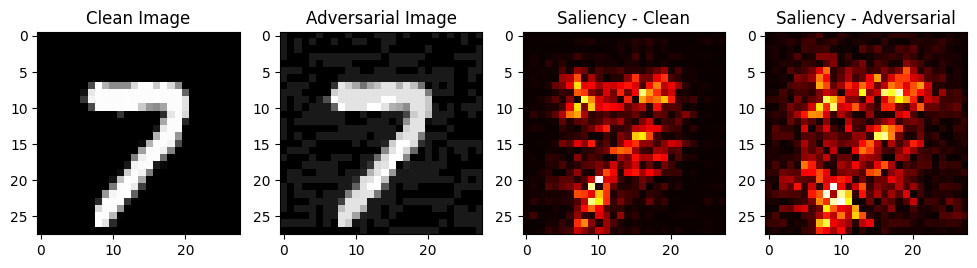

In [20]:
# Plot Results
fig, axes = plt.subplots(1, 4, figsize=(12, 5))
axes[0].imshow(sample_image.detach().cpu().squeeze().numpy(), cmap='gray')
axes[0].set_title("Clean Image")
axes[1].imshow(adversarial_image.detach().cpu().squeeze().numpy(), cmap='gray')
axes[1].set_title("Adversarial Image")
axes[2].imshow(clean_saliency.squeeze(), cmap='hot')
axes[2].set_title("Saliency - Clean")
axes[3].imshow(adversarial_saliency.squeeze(), cmap='hot')
axes[3].set_title("Saliency - Adversarial")
plt.show()

### Results
The the model predicted the adversarial example correctly, indicating robustness to this specific perturbation. The saliency maps for both clean and adversarial images appear slightly similar, suggesting that feature importance did not change significantly.

So, our Null Hypothesis is **NOT** rejected, as the model does not exhibit significant differences in feature importance between clean and adversarially modified images

### Conclusion
Using saliency maps - an explainable deep learning technique - I analyzed the feature importance of a CNN trained on MNIST for both clean and adversarial images.

The results showed no significant differences in feature importance, and the model correctly classified adversarial examples, demonstrating robustness to small perturbations. This highlights the value of explainable methods like saliency maps in understanding model behavior and verifying its reliability under adversarial conditions.
